<a href="https://colab.research.google.com/github/NilsBahr94/Master_Thesis_Algorithmic-Bias-in-AI/blob/Develop/Master_Thesis_Algorithmic_Bias_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Import packages

### Basic 

In [0]:
# Install relevant libraries
!pip install plotnine  
!pip install pandas
!pip install plotly

In [0]:
# Basic Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
# Import train_test_split
from sklearn.model_selection import train_test_split
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Learning Curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

### Fairness Tools

In [0]:
# Installation

!pip install aif360
# https://github.com/IBM/AIF360/blob/master/examples/README.md

!pip install aequitas
# https://github.com/dssg/aequitas

!pip install audit-AI
# https://github.com/pymetrics/audit-ai

!pip install responsibly
# https://docs.responsibly.ai/

In [0]:
# Import

import aif360
import aequitas
import auditai

### What-If Tool

In [0]:
# Install current tensorflow version

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.0/python3.6
Requires: tensorflow-estimator, grpcio, google-pasta, termcolor, gast, keras-applications, numpy, protobuf, tensorboard, six, wheel, absl-py, keras-preprocessing, astor, wrapt, opt-einsum
Required-by: tensorflow-federated, stable-baselines, magenta, fancyimpute
     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
     |████████████████████████████████| 3.9MB 46.2MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.

In [0]:
# Install the What-If Tool
try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define Helper Functions for the What-If tool
import pandas as pd
import numpy as np
import witwidget

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

# Case Studies

**Criteria for Dataset Selection**

https://www.notion.so/techlabs/Master-Thesis-Proposal-c1550763e23c485887147f59cebc695d#350e14b5c061432189b80eb1df2a81c5

## 1) US Adult Income Dataset

UCI Adult dataset, also known as "Census Income" dataset, contains information, extracted from the 1994 census data about people with attributes such as age, occupation, education, race, sex, marital-status, native-country, hours-per-week etc., indicating whether the income of a person exceeds $50K/yr or not. It can be used in fairness-related studies that want to compare gender or race inequalities based on people’s annual incomes, or various other studies [6]. 

### Data Import

In [0]:
# Import dataset and convert to Pandas Dataframe 

# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df_3_adult = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

### Exploratory Data Analysis 1

*Outcomes*:

1. Understanding of the general structure of the dataset
2. Understanding of basic statistics of the features of the dataset 


In [0]:
df_3_adult.head(n=5)

In [0]:
# Number of rows and features
df_3_adult.shape

(32561, 15)

In [0]:
# List of specific features
df_3_adult.columns

In [0]:
# Datatypes of features
print(df_3_adult.dtypes)

In [0]:
df_3_adult.info

In [0]:
df_3_adult.describe()

**Summary of results**

1. Understanding of the general structure 
- Result: 
2. Understanding of basic statistics of the features of the  the dataset 
- Result: 



### Data Preprocessing 1

**Outcomes**:

- Data Types of features are in a correct data type format

In [0]:
# Data Type Conversion
# Template

df["C"] = df["C"].astype("float")
df["C"] = df["C"].astype("int")
df["C"] = df["C"].astype("object")


### Exploratory Data Analysis 2

**Outcomes**:

1. Identification of **features** on the basis of which subpopulations can be identified and discrimination can happen
2. Identification of **values** of these features that are connected to certain subpopulations
3. Identification of the percentage of certain subpopulation based on the values of these features -> *Sample Size Disparity I*
4. Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset -> *Sample Size Disparity II*
5. Identification of the target feature and the type of class balance
6. Identification of percentage of missing values per feature
7. Identification of severity of outliers per feature
8. Identification of the distribution of class values (for majority and minority)

1) **Identification of features on the basis of which subpopulations can be identified and discrimination can happen**

-> ***Race, Sex, Country, Workclass***

In [0]:
print(df_3_adult.columns)
print(df_3_adult.columns.nunique())

2) **Identification of values of these features that are connected to certain subpopulations**

In [0]:
# Race
print(df_3_adult.Race.unique())
print(df_3_adult.Race.nunique())

['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
5


In [0]:
# Sex
print(df_3_adult.Sex.unique())
print(df_3_adult.Sex.nunique())

['Male' 'Female']
2


In [0]:
# Country
print(df_3_adult.Country.unique())
print(df_3_adult.Country.nunique())

In [0]:
# Workclass
print(df_3_adult.Workclass.unique())
print(df_3_adult.Workclass.nunique())

In [0]:
# Education
print(df_3_adult.Education.unique())
print(df_3_adult.Education.nunique())

In [0]:
# Template for Group By Statistics 
print(df_3_adult.groupby("Race")["Capital-Gain"].agg([min, max, "mean"])) 

# print(df_3_adult.groupby(["Sex", "Race"])["Capital-Gain"].mean())

`Interim Conclusion regarding 2) `

Mainly *Race* as well as *Sex* are the features on the basis of which discrimination could happen.

3) **Identification of the percentage of certain subpopulation based on the values of these features** -> *Sample Size Disparity I*

In [0]:
# Visualization of Count Columns

def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()


In [0]:
# Absolute number of members of different "races"
print(df_3_adult.Race.value_counts(dropna=False, sort=True)) # Learning: würde genauso mit df_3_adult["Race"].value_counts(dropna=False) funktionieren

# Percentage of members of different "races"
print(df_3_adult.Race.value_counts(normalize=True, dropna=False, sort=True))

In [0]:
# Distribution for Race

target_distribution(y_var="Race", data=df_3_adult)

In [0]:
# Absolute number of members of different "sexes"
print(df_3_adult.Sex.value_counts(dropna=False, sort=True))

# Percentage of members of different "sexes"
print(df_3_adult.Sex.value_counts(normalize=True, dropna=False, sort=True))

In [0]:
# Distribution for Sex

target_distribution(y_var="Sex", data=df_3_adult)

`Interim conclusion regarding 3)`



4) **Identification of the percentage of certain cross-sectional subpopulations based on the overall dataset** -> *Sample Size Disparity II*

In [0]:
# Count
df_3_adult.groupby(['Sex', 'Race']).agg({"Over-50K": 'count'})

In [0]:
# Alternative Count
df_3_adult_aggr = df_3_adult
df_3_adult_aggr['counting']=1
# df_3_adult_aggr.groupby(['Sex', 'Race']).agg({"counting": 'count'})

# To Do -> Jeweils verrechnen mit Grundgesamtheit von Subpopulationen

Histogram

In [0]:
# Define Histogram Function

def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)
        
    plt.show()

In [0]:
Y_columns = ["Race", "Sex"]

print(plot_histo(data = df_3_adult, col='Capital-Gain',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Capital-Loss',Y_columns=Y_columns))
print(plot_histo(data = df_3_adult, col='Hours-per-week',Y_columns=Y_columns))

Bar Plot 

In [0]:
# Define Function for Bar Plot

def plot_bar(data, col, Y_columns, max_cat=10):
    df = data.copy()
    
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].barh(cnt.index.values, cnt.values)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Bar plot of the "+col+" column by "+y_col)

    plt.show()

In [0]:
print(df_3_adult.columns)

Y_columns = ["Race"]

print(plot_bar(data = df_3_adult, col='Sex',Y_columns=Y_columns)) # Error because values for two subplots are expected

5) **Identification of the target feature and the type of class balance**

In [0]:
print(df_3_adult["Over-50K"].value_counts(dropna=False))
print(df_3_adult["Over-50K"].value_counts(normalize=True, dropna=False))

0    24720
1     7841
Name: Over-50K, dtype: int64
0    0.75919
1    0.24081
Name: Over-50K, dtype: float64


6) **Identification of percentage of missing values per feature**

In [0]:
print(df_3_adult.isna().any())
print(df_3_adult.isna().sum())

In [0]:
def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [0]:
assess_NA(df_3_adult)

Plot missing values per feature.

In [0]:
# Define Function 

def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100

    trace = go.Bar(x=data_null.index, y=data_null['Count'], marker=dict(color='#c0392b'),
              name = 'At least one missing value', opacity=0.9)
    layout = go.Layout(barmode='group', title='Column with missing values in the dataset', showlegend=True,
                   legend=dict(orientation="h"), yaxis=dict(title='Percentage of the dataset'))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

`Interim conclusion on 6)`

No problems with NA

**To Do**: Determine if NA are encrypted in different format.

7) **Identification of severity of outliers per feature**

Show boxplot per numeric feature

In [0]:
df_3_adult.info()

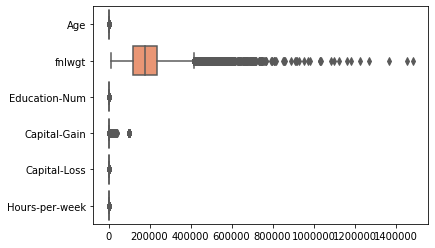

In [0]:
# Overview boxplot of all numerical features 
ax = sns.boxplot(data=df_3_adult, orient="h", palette="Set2")

In [0]:
# Age Boxplot
fig = px.box(df_3_adult, y="Age")
fig.show()

In [0]:
# Education Num
fig = px.box(df_3_adult, y="Education-Num")
fig.show()

In [0]:
# Capital Gain
fig = px.box(df_3_adult, y="Capital-Gain")
fig.show()

In [0]:
# Capital Loss
fig = px.box(df_3_adult, y="Capital-Loss")
fig.show()

In [0]:
# Hours per Week
fig = px.box(df_3_adult, y="Hours-per-week")
fig.show()

8) Identification of the distribution of class values (for majority and minority)

In [0]:
# To Do

#### Analysis with the What-If Tool

Guide: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/xgboost_caip.ipynb?hl=de


In [0]:
# Initialization of the What-If Tool

PROJECT_ID = 'YOUR_PROJECT_ID'
MODEL_NAME = 'YOUR_MODEL_NAME'
VERSION_NAME = 'YOUR_VERSION_NAME'
TARGET_FEATURE = 'mortgage_status'
LABEL_VOCAB = ['denied', 'approved']

config_builder = (WitConfigBuilder(test_examples.tolist(), features.columns.tolist() + ['mortgage_status'])
  .set_ai_platform_model(PROJECT_ID, MODEL_NAME, VERSION_NAME, adjust_prediction=adjust_prediction)
  .set_target_feature(TARGET_FEATURE)
  .set_label_vocab(LABEL_VOCAB))

### Data Preprocessing 2

Tasks:
1. Convert the labels of the target variable into a suitable  format (binary integer).
2. Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy coding).
3. Prepare data for training (input features and label).
4. Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that (*TBD if really the right approach*).

1) Convert the labels of the target variable into a suitable  format (binary integer)

In [0]:
# Encoding Binary Variables

df_3_adult["Over-50K"] = df_3_adult["Over-50K"].apply(lambda val:
1 if val == ">50K" else 0)

# Check if encoding was successful 
print(df_3_adult["Over-50K"].dtypes)

int64


2) Prepare data for training (input features and label).

In [0]:
# Prepare datasets for cross-validation

# Features of complete dataset
print(df_3_adult.columns)

# Input features
df_3_adult_train_input = df_3_adult.drop(columns=["Over-50K"])
print(df_3_adult_train_input.columns)

# Target feature
df_3_adult_train_label = df_3_adult["Over-50K"]
print(df_3_adult_train_label)

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country',
       'Over-50K'],
      dtype='object')
Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-Gain', 'Capital-Loss', 'Hours-per-week', 'Country'],
      dtype='object')
0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Over-50K, Length: 32561, dtype: int64


3) Prepare data as such that machine learning classification algorithm can handle that properly (e.g. standardization, normalization, feature scaling, dummy encoding)

In [0]:
# Dummy 
df_3_adult_train_input = pd.get_dummies(df_3_adult_train_input)

4) Filter dataset based on certain feature values which identify subpopulations and create different dataset versions based on that

In [0]:
# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]

print(df_3_adult.shape)
print(df_3_adult_black.shape)
print(df_3_adult_white.shape)
print(df_3_adult_female.shape)
print(df_3_adult_male.shape)

### Modeling

Selection of classification method:

- **Linear** machine learning algorithms often have a high bias but a low variance.
    1. Logistic Regression
    2. Linear Discriminant Analysis
    3. Partial Least Squares Discriminant Analysis
- **Nonlinear** machine learning algorithms often have a low bias but a high variance.
    1. Nonlinear Discriminant Analysis
    2. Neural Networks
    3. Flexible Discriminant Analysis
    4. Support Vector Machines 
    5. K-Nearest Neighbors
    6. Naive Bayes
- Others
    1. Basic Classification Trees
    2. Random Forest
    3. Boosted Trees

In [0]:
# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#### Training

- Prepare data for training (split by input features and labels).
- Execute train/test split (if applicable).
- Train with selected classification method.
- Predict with selected classification method.

In [0]:
# Define algorithms
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
knn = KNeighborsClassifier(n_neighbors = 5)
log_reg = LogisticRegression()
svm = SVC(C = 1.0, kernel = "rbf")

f1 = make_scorer(f1_score)

# Estimate 
print(cross_val_score(estimator = random_forest, 
                X= df_3_adult_train_input, 
                y= df_3_adult_train_label, 
                cv= 10, 
                scoring= f1))
df_3_adult_train_label
# Predict and get confusion matrix 
y_train_pred = cross_val_predict(random_forest, df_3_adult_train_input, df_3_adult_train_label, cv = 10) 
print(confusion_matrix(df_3_adult_train_label, y_train_pred)) 
print(f1_score(df_3_adult_train_label, y_train_pred))

[0.56134723 0.55464927 0.57258719 0.54681027 0.58556367 0.57491857
 0.54636591 0.59934853 0.57894737 0.54440789]
[[23791   929]
 [ 4399  3442]]
0.5637078283655421


#### Testing & Model Evaluation

1. Get basic model performance metrics. 
2. Understand the predictive ability of the features.
3. Understand class separability.
4. Understand the structure of the subpopulation.


1) Get basic model performance metrics of the base model.

In [0]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
# Get Basic Performance Statistics

# Confusion Matrix
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_train, y_train_pred))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred) # Validate if the correct data was used
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='k-NN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC Curve')
plt.show();

# AUC 
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred)) # Validate if the correct data was used

# Full Classification Metrics Report
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

# Visual Model Evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

2) Understand the predictive ability of the features

See *Chapter 18.2 Categorical Outcomes* in *Applied Predictive Modeling*.

Approaches:

- Plot ROC Curve per predictor variable 
- See metrics such as p-value and gain ratio 
- Relief algorithm
- For Random Forest: Gini Importance or Mean Decrease in Impurity (MDI)
- LIME
- SHAP

See https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-understand-a-model

In [0]:
# Feature Importance for Random Forest

for i, item in enumerate(rfr.feature_importances_):
  print("{0:s}: {1:.2f}".format(X.columns[i], item))

#### Fairness Evaluation

From https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml/#2

In [0]:
# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

In [0]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], 
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [0]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [0]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

#### Learning Curve

##### Function Definition

In [0]:
# https://www.kaggle.com/grfiv4/learning-curves-1

import numpy  as np
import pandas as pd

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              For example, Log Loss is specified as 'neg_log_loss'
              
    obj_line : numeric or None (default: None)
               draw a horizontal line 
               

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
        
    Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
        
    Usage
    -----
        plot_learning_curve(estimator = best_estimator, 
                            title     = best_estimator_title, 
                            X         = X_train, 
                            y         = y_train, 
                            ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

         plt.show()
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    # plt.style.use('seaborn')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

##### Plot Learning Curve

In [0]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
random_forest = RandomForestClassifier(n_estimators = 100, # To Do 
                                       max_depth = 12)


sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Plot actual learning curve

# plt.figure(figsize = (30,10))
plot_learning_curve(estimator = random_forest, 
                    title = "Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    cv = 10, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = sizes)

from matplotlib.pyplot import figure
# plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

##### Hyperparameter Tuning

Steps in a Grid Search:
1. An algorithm to tune the hyperparameters. (Sometimes called an ‘estimator’)
2. Defining which hyperparameters we will tune
3. Defining a range of values for each hyperparameter
4. Setting a cross-validation scheme; and
5. Define a score function so we can decide which square on our grid was "the best"
6. Include extra useful information or functions

In [0]:
# Check scores

from sklearn import metrics
sorted(metrics.SCORERS.keys())

# make scorer if that does not work with the default names

In [0]:
from sklearn import model_selection

# Create the hyperparameter grid
param_grid = {'max_depth': [2, 4, 6, 8],            # Important: Keys in the dictionary must be valid hyperparameters 
              'min_samples_leaf': [1, 2, 4, 6]}

# Define classifier
rf_grid_search = RandomForestClassifier(criterion= "entropy",
                                        max_features = "auto")

grid_rf_class = sklearn.model_selection.GridSearchCV(estimator = model,
                                                     param_grid = param_grid, 
                                                     scoring= 'f1', 
                                                     cv = 5,
                                                     refit = True, 
                                                     n_jobs = 2,
                                                     return_train_score = True)



type(grid_rf_class.best_estimator_) # grid_rf_class.best_estimator_ is an estimator that we can directly use for fitting and prediction
print(grid_rf_class.best_estimator_) # print in order to check actual final hyperparameters 

# Outputs
# Three different groups for the GridSearchCV properties;
# 1. A results log: cv_results_
# 2. The best results: best_index_ , best_params_ & best_score_
# 3. 'Extra information': scorer_ , n_splits_ & refit_time_

# Access properties with dot notation
# e.g. grid_search_object.property

cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
print(best_row)


# Further steps with best model

# We can use the best model by means of the score to fit it on our data and make predictions
grid_rf_class.fit(X_train, y_train) # To Do: specify dataset variable name
# Make predictions
grid_rf_class.predict(X_test)       # To Do: specify dataset variable name

In [0]:
# Random Search



##### Compare different algorithms

In [0]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Setup classifiers 
# a) Linear
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# b) Nonlinear
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
# c) Others
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# Define different classification algorithms
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
# knn = KNeighborsClassifier(n_neighbors = 5)
log_reg = LogisticRegression()
svm = SVC(C = 1.0, kernel = "rbf")

# Store different models in a list
models = [random_forest, log_reg, svm]

# Define other input arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Plot learning curve for different classifcation algorithms
for model in models:
  plt.subplot
  plot_learning_curve(estimator = model, 
                      title = f"{model} Learning Curve", 
                      X = df_3_adult_train_input, y = df_3_adult_train_label, 
                      cv = 10, 
                      scoring = f1, 
                      ylim = (0, 1), 
                      train_sizes = sizes)

# Plot different subplots 

# for model, i in [(RandomForestClassifier(), 1), (KNeighborsClassifier(),2)]:
#     plt.subplot(1,2,i)
#     learning_curves(estimator = model, 
#                     data = df_3_adult_dummies, 
#                     features = df_3_adult_train_input.columns, 
#                     target= "Over-50K", 
#                     train_sizes = train_sizes, 
#                     cv= 5)

##### Approach 1: Take whole dataset (maj. + min.)

In [0]:
# Pseudo Code

dataset = pd.read_csv("Path")

dataset_maj = df_3_adult[df_3_adult["Sensitive Attribute"] == "Majority Value"] 
dataset_min = df_3_adult[df_3_adult["Sensitive Attribute"] == "Minority Value"]

min_sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000]

             # Noch einbauen, wenn hohe Anzahl von Training Examples für Subpopulation nicht gegeben, 
             # dann einfach stoppen.

diff_min_datasets = []

def get_min_datasets(data, ):
  for specific_size in min_sizes:
    dataset_min_slice = training_examples.shuffle # shuffle dataset with minority group randomely before slicing
    dataset_min_slice = dataset_min_slice.slice[min_sizes]
    diff_min_datasets.append(dataset_min) #
  
  for specific_mind_dataset in diff_min_datasets:
      

  dataset_min_slice = 


# if min_sizes < len(data): # Das in einen for loop einbetten
#   stop

# Ggf. feature importance für jede Iteration auch noch berechnen und dann ans DF anhängen

# Sample Code

# neighbors_list = [3,5,10,20,50,75]      # use either the one or the other neighbors_list 
# neighbors_list = list(range(5,500, 5))
# print(np.linspace(1,2,5))

# accuracy_list = []
# for test_number in neighbors_list:
#   model = KNeighborsClassifier(n_neighbors=test_number)
#   predictions = model.fit(X_train, y_train).predict(X_test)
#   accuracy = accuracy_score(y_test, predictions)
#   accuracy_list.append(accuracy)

  # Because I will be working with k-fold cv, most likely I will need to take the average 
  # and define the standard deviation (which then can also be shown in the plot as bands)

  # Important: Get score both training and testing 

# results_df = pd.DataFrame({'neighbors':neighbors_list, 'accuracy':accuracy_list})
# print(np.linspace(1,2,5))

# Matplotlib plotting code -> Alternatively, use plotly

# plt.plot(results_df['neighbors'],
# results_df['accuracy'])
# # Add the labels and title
# plt.gca().set(xlabel='n_neighbors', ylabel='Accuracy',
# title='Accuracy for different n_neighbors')
# plt.show()


# Sample Code for nested for-loop 

# results_list = []
# for learn_rate in learn_rate_list:
#   for max_depth in max_depth_list:
#     for subsample in subsample_list:
#       for max_features in max_features_list:
#         results_list.append(gbm_grid_search(learn_rate,max_depth, subsample,max_features))

# results_df = pd.DataFrame(results_list, columns=['learning_rate', 'max_depth', 'subsample', 'max_features','accuracy'])
# print(results_df)

# Dataframe 

# results_df = pd.DataFrame(results_list, columns=['learning_rate', 'max_depth', 'accuracy'])
# print(results_df)




##### Approach 2: Take slice of dataset (min.)

In [0]:
# Slice code for minority example

# Setup slices of the dataset
is_black = df_3_adult["Race"].isin(["Black"])
is_white = df_3_adult["Race"].isin(["White"])
is_female = df_3_adult["Sex"].isin(["Female"])
is_male = df_3_adult["Sex"].isin(["Male"])

# Create filtered version of the dataset
# Minority group
df_3_adult_black = df_3_adult[is_black]
df_3_adult_female = df_3_adult[is_female]
# Majority group
df_3_adult_white = df_3_adult[is_white]
df_3_adult_male = df_3_adult[is_male]

In [0]:
# Dummy coding for slice

df_3_adult_black_dummies = pd.get_dummies(df_3_adult_black)

In [0]:
# Features of complete dataset
print(df_3_adult.columns)

# Input features
df_3_adult_black_input = df_3_adult_black_dummies.drop(columns=["Over-50K"])
print(df_3_adult_black_input.columns)

# Target feature
df_3_adult_black_label = df_3_adult_black_dummies["Over-50K"]
print(df_3_adult_black_label)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6

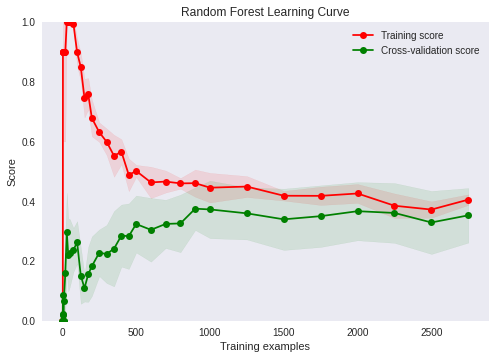

In [0]:
# Learning Curve for Slice 
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Define arguments
f1 = make_scorer(f1_score) # theoretically, set (zero_division=1)
random_forest = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 12)
sizes_minority = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
                  350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
                  2000, 2250, 2500, 2750] 

# sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
#                   350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
#                   2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
#                   4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000] 

# Plot actual learning curve

# plt.figure(figsize = (30,10))
plot_learning_curve(estimator = random_forest, 
                    title = "Random Forest Learning Curve", 
                    X = df_3_adult_black_input, y = df_3_adult_black_label, 
                    cv = 10, 
                    scoring = f1, 
                    ylim = (0, 1), 
                    train_sizes = sizes_minority)

from matplotlib.pyplot import figure
# plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

## 2) COMPAS Dataset

The COMPAS dataset contains records for defendants from Broward County indicating their jail and prison times, demographics, criminal histories, and COMPAS risk scores from 2013 to 2014 [75].

See: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS.ipynb#scrollTo=67DYIFxoevt2

### Data Import

In [0]:
# Read training dataset from CSV

# TO DO: Check if dataset from link below matches dataset from Github repository: https://github.com/propublica/compas-analysis/

df_1_compas = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')
df_1_compas


### Exploratory Data Analysis 1

In [0]:
# Data Visualization with ggplot2
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg

%matplotlib inline

(ggplot(data = mpg)         # defining what data to use
 + aes(x='class')    # defining what variable to use
 + geom_bar(size=20) # defining the type of plot to use
)

#### Analysis with What-If Tool

### Data Preprocessing

To Do's:

- Filter Dataset based on the Subpopulations

### Exploratory Data Analysis 2

### Modeling

In [0]:
# Split into training and test set

#### Training

#### Testing & Model Evaluation

Inspiration: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Age_Regression.ipynb#scrollTo=jlwjF-Nnmoww

In [0]:
# Installation of the What-If Tool

try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

In [0]:
# Define helper functions

import pandas as pd
import numpy as np
import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64) or df[f].dtype is np.dtype(np.int32):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64) or df[col].dtype is np.dtype(np.int32):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

Hint

## 3) Homicide Dataset

### Data Import

In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2_Homicides_database.csv to 2_Homicides_database (2).csv


In [0]:
import _io
df_2_homicide = pd.read_csv(io.StringIO(uploaded['2_Homicides_database (2).csv'].decode('utf-8')))
df_2_homicide

In [0]:
# Initialize Data Import option 

from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = "https://drive.google.com/open?id=1x27KDf6_fgqYHwccAb6U4h3HAh60eK2z"
df_2_homicide = pd.read_csv(path)
# Dataset is now stored in a Pandas Dataframe

### Exploratory Data Analysis 1

### Data Preprocessing

### Exploratory Data Analysis 2

### Modeling

## 4) German Credit Dataset

The German Credit dataset contains 1000 credit records containing attributes such as personal status and sex, credit score, credit amount, housing status etc. It can be used in studies about gender inequalities on credit-related issues [42].

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]  # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_4_german = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_4_german

## 5) Communities and Crime Dataset

The Communities and Crime dataset gathers information from different communities in the United States related to several factors that can highly influence some common crimes such as robberies, murders or rapes. The data includes crime data obtained from the 1990 US LEMAS survey and the 1995 FBI Unified Crime Report. It also contains socio-economic data from the 1990 US Census.

### Data Import

In [0]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"] # TO DO

# Read the dataset from the provided CSV and print out information about it.
df_5_communities = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df_5_communities

# Generalizable Rule 

## Learning Curves

Helpful Links: 

-   https://github.com/laxmimerit/Learning-Curve-Machine-Learning-in-Python-KGP-Talkie/blob/master/Learning%20Curve%20Machine%20Learning%20in%20Python%20KGP%20Talkie.ipynb -> Learning Curve Tutorial
-   https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
-   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html



In [0]:
# Import all relevant packages and modules

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

### Templates

**Learning Curve Variant 1**



In [0]:
# Define plot_curve function

def plot_curve():
    # instantiate
    lg = LinearRegression()

    # fit
    lg.fit(X, y)
    
    
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    train_sizes, train_scores, test_scores = learning_curve(lg, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

Compared to the theory we covered, here our y-axis is 'score', not 'error', so the higher the score, the better the performance of the model.

Training score (red line) decreases and plateau
Indicates underfitting
High bias
Cross-validation score (green line) stagnating throughout
Unable to learn from data
Low scores (high errors)
Should tweak model (perhaps increase model complexity)

**Learning Curve Variant 2**

In [0]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Implementation on Case Study Datasets

# Deprecated

In [0]:
# II. Model setup
# a) Linear

# b) Nonlinear
# K-NN
# knn = KNeighborsClassifier(n_neighbors=6) # To Do: Check appropriatness of hyperparameter
# knn.fit(df_3_adult_train_input, df_3_adult_train_label) 
# To Do: Probably wrong because whole dataset and not only training set is used as input training

# c) Others
# Random Forest
# random_forest = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs =-1)
#  random_forest.fit(df_3_adult_train_input, df_3_adult_train_label)
# To Do: Probably wrong because whole dataset and not only training set is used as input training

In [0]:
# Execute train/test split.

# Check: Probably not necessary 

# Execute Train/test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_3_adult_train_input, 
#                                                     df_3_adult_train_label, 
#                                                     test_size=0.3, 
#                                                     random_state=21) # seed for random number generator

In [0]:
# Plot Alternative 2
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
    go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [0]:
# Plot Alternative 1
# fig = px.bar(df_3_adult_aggr, x="Race", y="counting", color='Sex', barmode='group')
# fig.show()

# Hint: Does not work properly.

# Plot Alternative 2
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Bar(name='Male', x=df_3_adult_aggr["Race"], y=df_3_adult_aggr["counting"]),
#     go.Bar(name='Female', x=df_3_adult_aggr["Sex"], y=df_3_adult_aggr["counting"])
# ])
# # Change the bar mode
# fig.update_layout(barmode='group')
# fig.show()

## Learning Curve Variants

### Variant 1

In [0]:
# Define Learning Curve Function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [0]:
plot_learning_curve(estimator = random_forest, title = "Random Forest Learning Curve", 
                    X = df_3_adult_train_input, y = df_3_adult_train_label, 
                    axes=None, ylim=None, cv=10, train_sizes=sizes)
 
# models = []

# for model in models:
#   plot_learning_curve(estimator=model, title="k-nn Learning Curve", X = df_3_adult_train_input, y = df_3_adult_train_label, 
#                     axes=None, ylim=None, cv=10,
#                     n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

### Variant 2

In [0]:
!pip install yellowbrick

In [0]:
# https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Encode the categorical data
X = df_3_adult_train_input
y = df_3_adult_train_label

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
# sizes = np.linspace(0.1, 1.0, 10)
sizes = [5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300,
             350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750,
             2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500,
             4750, 5000, 6000, 7000, 8000, 9000, 10000, 15000]

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    model = random_forest, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Variant 3

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# train_sizes = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

from sklearn.model_selection import learning_curve

# features = df_3_adult_train_input.columns
# target = df_3_adult_train_label

train_sizes, train_scores, validation_scores = learning_curve(estimator = random_forest, 
                                                              X = df_3_adult_train_input, 
                                                              y = df_3_adult_train_label, 
                                                              cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a knn model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

In [0]:
### Bundling our previous work into a function ###

def learning_curves(estimator, data, features, target, train_sizes, cv, scoring):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, data[features], data[target], train_sizes = train_sizes,
        cv = cv, scoring = scoring)
    
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

In [0]:
### Plotting the two learning curves ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize = (16,5))

for model, i in [(RandomForestClassifier(), 1)]:
    plt.subplot(1,2,i)
    learning_curves(estimator = random_forest, 
                    data = df_3_adult_dummies, 
                    features = df_3_adult_train_input.columns, 
                    target= "Over-50K", 
                    train_sizes = sizes,
                    scoring = f1, 
                    cv= 10)